In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wdf = pd.read_csv('weatherMonroe.csv', low_memory=False)
wdf = wdf.drop(['NAME','MDPR','MDSF','STATION'], axis=1)
wdf = wdf.rename(columns={'DATE':'Date'})
wdf['Date'] = wdf['Date'].astype('datetime64[ns]')

In [3]:
#Create df from hatchery file
esc = pd.read_csv('skykomishHatcheries.csv', low_memory=False)
esc['Date'] = pd.to_datetime(esc['Date'])
esc = esc[['Date', 'Facility', 'Adult Count', 'Species', 'Event']]
esc = esc[esc.Facility == 'WALLACE R HATCHERY']
esc = esc[esc.Event == 'Trap Estimate']
esc = esc[esc.Species == 'Coho']
esc = esc.sort_values('Date')



#Creat df from rivers file
df = pd.read_csv('sky.txt', sep='\t', header=None)
df = df.rename(columns ={2:"Date",3:"cfs"})
df = df.drop(columns=[0,1,4],)
df['Date'] = df['Date'].astype('datetime64[ns]')
df.head()

#Specify date range for each species
df_time = esc
first = df_time.iloc[0].Date
last = df_time.iloc[-1].Date
print(first, last)

#Merge data frames and trim for species date range
plt_tst = pd.merge(df, esc, on=['Date'], how='outer')
rt = (plt_tst['Date'] >= first) & (plt_tst['Date'] <= last)
plt_tst = plt_tst.loc[rt]
plt_tst['Year'] = plt_tst['Date'].dt.strftime('%Y').astype(np.int64)
plt_tst = plt_tst[plt_tst.Year <= 2015]
plt_tst.info()
plt_tst['Adult Count'] = plt_tst['Adult Count'].fillna(0).astype(np.int64)
plt_tst['returnBinary'] = plt_tst['Adult Count'].astype(np.int64)
plt_tst.loc[plt_tst.returnBinary > 0, 'returnBinary'] = 1
plt_tst.info()
plt_tst.head()

1997-09-23 00:00:00 2020-11-12 00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6681 entries, 82 to 6762
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6681 non-null   datetime64[ns]
 1   cfs          6681 non-null   int64         
 2   Facility     263 non-null    object        
 3   Adult Count  263 non-null    float64       
 4   Species      263 non-null    object        
 5   Event        263 non-null    object        
 6   Year         6681 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 417.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6681 entries, 82 to 6762
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          6681 non-null   datetime64[ns]
 1   cfs           6681 non-null   int64         
 2   Facility      263

,Date,cfs,Facility,Adult Count,Species,Event,Year,returnBinary
82,1997-09-23,1720,WALLACE R HATCHERY,3000,Coho,Trap Estimate,1997,1
83,1997-09-24,1530,NaN,0,NaN,NaN,1997,0
84,1997-09-25,1410,NaN,0,NaN,NaN,1997,0
85,1997-09-26,1780,NaN,0,NaN,NaN,1997,0
86,1997-09-27,7570,NaN,0,NaN,NaN,1997,0


In [4]:
tf = plt_tst.groupby('Year').sum('Adult Count')
sf = plt_tst.set_index('Year')
sf = sf.merge(tf, on='Year')
sf = sf[['Adult Count_x', 'cfs_x','Date','returnBinary_y', 'Adult Count_y','returnBinary_x']]
sf = sf.rename(columns = {'Adult Count_x':'Count', 'cfs_x':'cfs','returnBinary_y':'#obsv','returnBinary_x':'returnBinary','Adult Count_y':'yearTotal'})
sf['%total'] = sf.Count/sf.yearTotal
# sf = sf.set_index('Date')
sf.head(20)

,Count,cfs,Date,#obsv,yearTotal,returnBinary,%total
Year,,,,,,,
1997,3000,1720,1997-09-23,8,20000,1,0.15
1997,0,1530,1997-09-24,8,20000,0,0.00
1997,0,1410,1997-09-25,8,20000,0,0.00
1997,0,1780,1997-09-26,8,20000,0,0.00
1997,0,7570,1997-09-27,8,20000,0,0.00
1997,0,4720,1997-09-28,8,20000,0,0.00
1997,0,3590,1997-09-29,8,20000,0,0.00
1997,1000,2900,1997-09-30,8,20000,1,0.05
1997,0,3510,1997-10-01,8,20000,0,0.00


In [5]:
from fbprophet import Prophet

In [6]:
model1 = Prophet(daily_seasonality = False, weekly_seasonality = True, yearly_seasonality = True, interval_width = 0.95)
history = sf.rename(columns = {"Date":"ds", "%total":"y"}, inplace = False)

model1.fit(history)

In [7]:
forecast = model1.predict()

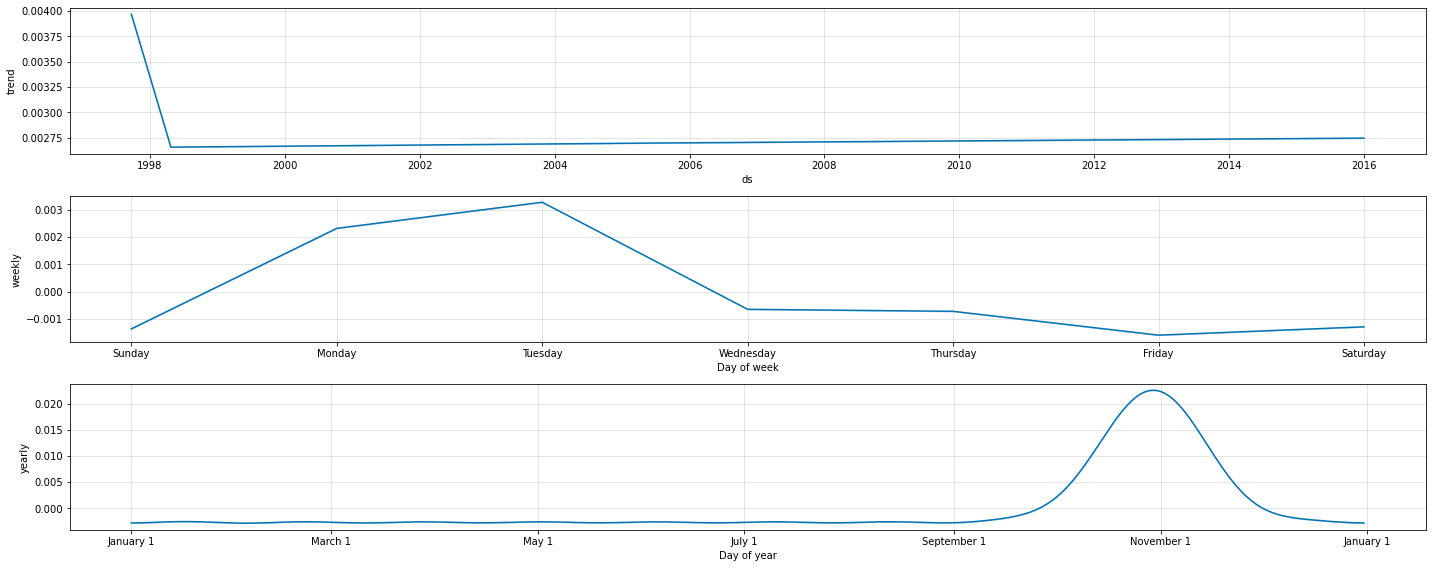

In [8]:
fig = model1.plot_components(forecast, figsize = (20, 8))
fig.savefig('model1', bbox_inches = 'tight')

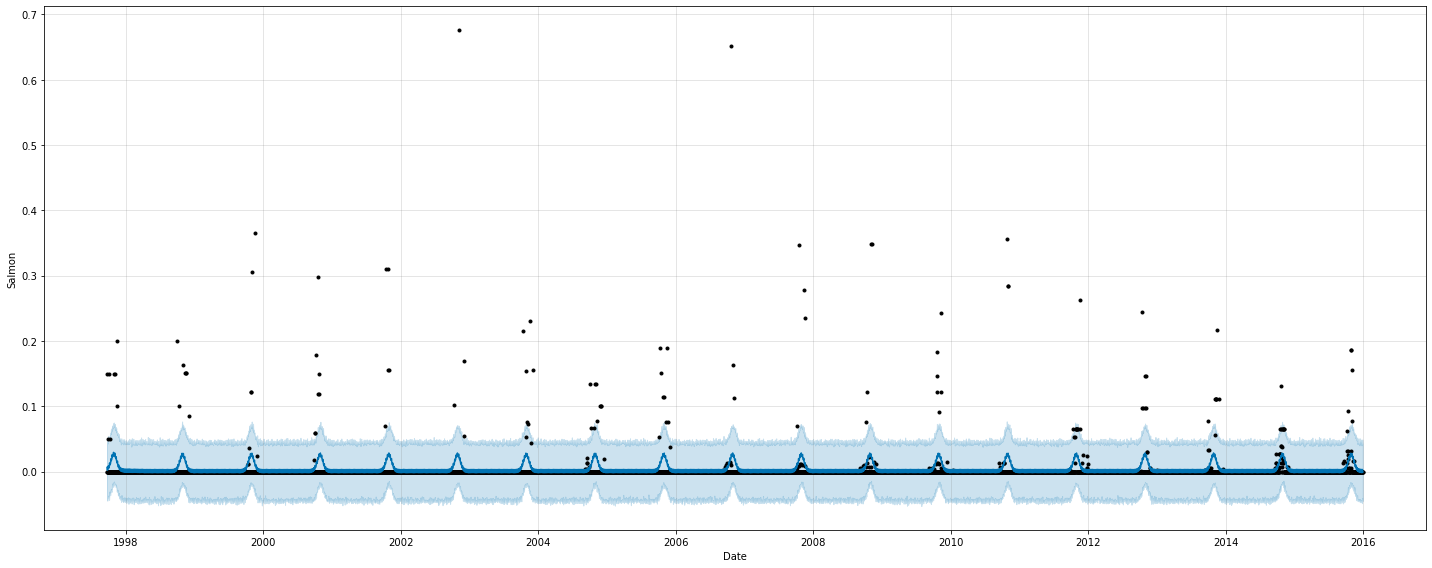

In [9]:
fig = model1.plot(forecast, xlabel = "Date", ylabel = "Salmon", figsize = (20, 8))
fig.savefig('model_pred', bbox_inches = 'tight')